In [ ]:
import os
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans 
import xgboost as xgb
from datetime import datetime  
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from statistics import stdev
from statistics import mean
from sklearn.model_selection import KFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras import losses
from keras import optimizers
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import plot_model
from keras.models import load_model
import keras.backend as K
import tensorflow as tf


# 1 Data Gathering and Preparation
## 1.1 Data pipeline
### 1.1.1 query data from Big Query

First we went to 
https://cloud.google.com/docs/authentication/getting-started to set up an account and an API key. Then we queried data from Big Query with the JSON file that got downloaded. 

In [4]:
pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./Predict Taxi Travel Time-d65166414ba3.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../Predict Taxi Travel Time-d65166414ba3.json"
from google.cloud import bigquery
client = bigquery.Client()

### 1.1.2 fetch new data and retrain model

In [4]:
from google.cloud import bigquery
client = bigquery.Client()


query = (
    """SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    LIMIT 10"""
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year
0,1,2016-03-30 08:18:12+00:00,2016-03-30 08:44:56+00:00,1,8.20,-73.961937,40.767967,1,N,-74.014610,40.714081,1,28.0,0.0,0.5,5.75,0.00,0.3,34.55,1604,2016-03-30
1,1,2016-06-15 11:48:40+00:00,2016-06-15 12:33:04+00:00,1,5.40,-73.995689,40.764603,1,N,-74.010109,40.707829,1,29.0,0.0,0.5,5.96,0.00,0.3,35.76,2664,2016-06-15
2,1,2016-03-14 00:10:26+00:00,2016-03-14 00:23:30+00:00,1,8.00,-73.872993,40.774002,1,Y,-73.972687,40.750912,1,22.5,0.5,0.5,6.00,5.54,0.3,35.34,784,2016-03-14
3,2,2016-10-25 22:23:39+00:00,2016-10-25 22:38:26+00:00,1,8.33,NaN,NaN,1,N,NaN,NaN,1,24.0,0.5,0.5,5.06,0.00,0.3,30.36,887,2016-10-25
4,1,2016-03-09 23:28:26+00:00,2016-03-09 23:52:49+00:00,1,10.20,-74.002869,40.728580,1,N,-73.936104,40.846100,1,30.0,0.5,0.5,7.80,0.00,0.3,39.10,1463,2016-03-09


Here we join with the public available weather data. This isn't required, but the goal here is just to show you what's posisble
with big query. Spend some time exploring the public data and coming up with hypotheses!

In [9]:
query = (
    """   
    SELECT * FROM 
    (
    SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
     EXTRACT (YEAR FROM pickup_datetime) as year_of_year
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` ) a 
    LEFT JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) weather_data
    on CAST(a.date_of_year AS STRING)=weather_data.date_of_year2 WHERE CAST(year_of_year AS STRING)='2016'
    Order by date_of_year
    LIMIT 100"""
)
taxi_w=pd.io.gbq.read_gbq(query,dialect='standard')
taxi_w.head()


,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year,day_of_year,month_of_year,year_of_year,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,1,2016-01-01 12:19:32+00:00,2016-01-01 12:21:40+00:00,1,0.40,-73.999992,40.733124,1,N,-73.996094,40.738293,2,3.5,0.0,0.5,0.00,0.0,0.3,4.30,128,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
1,2,2016-01-01 06:43:01+00:00,2016-01-01 06:44:50+00:00,1,0.19,-73.951981,40.777630,1,N,-73.954849,40.778198,1,3.0,0.0,0.5,0.76,0.0,0.3,4.56,109,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
2,1,2016-01-01 14:31:52+00:00,2016-01-01 14:33:09+00:00,1,0.50,-73.952080,40.773232,1,N,-73.949753,40.779720,2,3.5,0.0,0.5,0.00,0.0,0.3,4.30,77,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
3,2,2016-01-01 10:36:43+00:00,2016-01-01 10:38:58+00:00,5,0.46,-73.969505,40.753567,1,N,-73.975426,40.752163,1,4.0,0.0,0.5,0.96,0.0,0.3,5.76,135,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
4,2,2016-01-01 22:48:28+00:00,2016-01-01 22:50:17+00:00,1,0.45,-73.989868,40.741032,1,N,-73.993759,40.736095,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,109,2016-01-01,1,1,2016,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0


Besides, we also add the performance in stock market into our model.

In [10]:
query = (
    """SELECT *
    FROM `predict-taxi-travel-time.GSPC.daily`
    order by Date
    LIMIT 10"""
    
)
stock_sample=pd.io.gbq.read_gbq(query,dialect='standard')
stock_sample.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2015-12-28,2057.770020,2057.770020,2044.199951,2056.500000,2056.500000,2492510000
1,2015-12-29,2060.540039,2081.560059,2060.540039,2078.360107,2078.360107,2542000000
2,2015-12-30,2077.340088,2077.340088,2061.969971,2063.360107,2063.360107,2367430000
3,2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000
4,2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000


## 1.2 Data integrity checks
### 1.2.1 missing values and outliers

There is no missing value in pickup time and dropoff time.

We remove the records that has missing value in pickup longtitude, pickup latitude, dropoff longtitude, dropff latitude.

For outlier, we will remove the trip with the following features:
<br>&emsp;&emsp; 1. Pickup or dropoff locations is outside New York City. We defined the citi boarder as longtitude between -74.26 and -73.69 and latitude between 40.49 and 40.92.
<br>&emsp;&emsp; 2. Trip distance has negative number or larger than 100 mile.
<br>&emsp;&emsp; 3. Travel time is over 15000 seconds or negative.
<br>&emsp;&emsp; 4. Average speed is over 100 mile per hour


In [17]:
query =  (
"""
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
  CASE
    WHEN x <=1 and x>=-1 THEN ACOS(x)
    ELSE NULL
  END
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
);
SELECT *
FROM
    (SELECT 
        * , (trip_distance*1000)/travel_time as speed # calculate speed for each trip
    FROM (
        SELECT 
            *,TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) as travel_time,
            CAST(EXTRACT(DATE FROM pickup_datetime) AS STRING) as date_of_year,
            EXTRACT(HOUR FROM pickup_datetime) as hour,
            HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        WHERE 
            pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            AND pickup_latitude > 40.49 AND pickup_latitude < 40.92 
            AND dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 
            AND pickup_longitude > -74.26 AND pickup_longitude< -73.69 
            AND dropoff_longitude > -74.26 AND dropoff_longitude < -73.69 
            AND trip_distance > 0 AND trip_distance < 100
    ) A
    WHERE travel_time > 0 and travel_time < 15000  ) B
WHERE 
    speed < 28 and RAND() < 0.0000001
order by pickup_datetime;
"""
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,date_of_year,hour,distance_in_km,speed
0,1,2016-03-06 09:18:25+00:00,2016-03-06 09:39:25+00:00,1,3.8,-73.997627,40.765152,1,N,-73.982521,40.728779,1,17.0,0.0,0.5,4.45,0.0,0.3,22.25,1260,2016-03-06,9,4.234268,3.015873
1,1,2016-03-18 23:47:16+00:00,2016-03-18 23:52:48+00:00,1,1.1,-73.976089,40.786324,1,N,-73.979698,40.776295,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,332,2016-03-18,23,1.154251,3.313253


### 1.2.2 information leakage

 We deleted **'trip_distance'**,**'fare_amount'**,**'tip_amount'**,'**tolls_amount'**,**'total_amount'**, since they are directly related to the travel time. And we cannot use them to predict travel time.

### 1.2.3 non-sensical or redundant variables

vendor_id, rate_code, store_and_fwd_flag, payment_type,extra and surcharge are redundant variables and we deleted.

## 1.3 Feature Engineering
### 1.3.1 convert categorical features

We converted month, day, weekday, hour to dummy variables. (i.e: 6 months to 6 dummy variables using one hot encoded) Specific sample code see below.

In [25]:
query = (
"""
    SELECT
                EXTRACT (DATE FROM pickup_datetime) as date_of_year,
                pickup_datetime,
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance,
                pickup_latitude,
                pickup_longitude,
                dropoff_latitude,
                dropoff_longitude,
                passenger_count
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        WHERE 
            pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and dropoff_longitude IS NOT NULL 
            AND pickup_latitude > 40.49 AND pickup_latitude < 40.92 
            AND dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 
            AND pickup_longitude > -74.26 AND pickup_longitude< -73.69 
            AND dropoff_longitude > -74.26 AND dropoff_longitude < -73.69 
            AND trip_distance > 0 AND trip_distance < 100
        limit 10
 """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')

,date_of_year,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count
0,2016-02-17,2016-02-17 12:44:17+00:00,1833,10.50,40.763367,-73.981140,40.773697,-73.870430,1
1,2016-04-28,2016-04-28 07:22:52+00:00,2127,7.39,40.786049,-73.950768,40.867279,-73.905830,1
2,2016-05-17,2016-05-17 08:39:35+00:00,3548,9.40,40.769150,-73.862549,40.754116,-73.986877,2
3,2016-05-26,2016-05-26 15:26:23+00:00,2112,9.80,40.755226,-73.984070,40.768360,-73.861664,1
4,2016-02-24,2016-02-24 14:00:45+00:00,1788,11.10,40.769760,-73.863510,40.765205,-73.975357,1


In [26]:
# Extract Month, Day, Weekday, Hour from pickup_datetime
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)  
df.loc[:,'pickup_day'] =  df['pickup_datetime'].dt.day
df.loc[:,'pickup_month'] =  df['pickup_datetime'].dt.month
df.loc[:,'pickup_hour'] =  df['pickup_datetime'].dt.hour
df.loc[:,'pickup_weekday'] =  df['pickup_datetime'].dt.weekday+1
# Convert catagorical variables to dummy variables using one hot encode
passenger_count = pd.get_dummies(df['passenger_count'], prefix='pc', prefix_sep='_')  
month = pd.get_dummies(df['pickup_month'], prefix='m', prefix_sep='_')   
dom = pd.get_dummies(df['pickup_day'], prefix='dom', prefix_sep='_')  
hour = pd.get_dummies(df['pickup_hour'], prefix='h', prefix_sep='_')  
dow = pd.get_dummies(df['pickup_weekday'], prefix='dow', prefix_sep='_')  
# merge the dummy variables to the origianl table
dat = pd.concat([df,  passenger_count, month,dom,hour,dow], axis=1)
dat.head()

,date_of_year,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,pickup_day,pickup_month,pickup_hour,pickup_weekday,pc_1,pc_2,pc_5,m_2,m_3,m_4,m_5,m_6,dom_1,dom_17,dom_20,dom_21,dom_24,dom_25,dom_26,dom_28,h_7,h_8,h_12,h_13,h_14,h_15,h_18,h_19,h_20,h_22,dow_1,dow_2,dow_3,dow_4,dow_7
0,2016-02-17,2016-02-17 12:44:17+00:00,1833,10.50,40.763367,-73.981140,40.773697,-73.870430,1,17,2,12,3,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2016-04-28,2016-04-28 07:22:52+00:00,2127,7.39,40.786049,-73.950768,40.867279,-73.905830,1,28,4,7,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2016-05-17,2016-05-17 08:39:35+00:00,3548,9.40,40.769150,-73.862549,40.754116,-73.986877,2,17,5,8,2,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,2016-05-26,2016-05-26 15:26:23+00:00,2112,9.80,40.755226,-73.984070,40.768360,-73.861664,1,26,5,15,4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,2016-02-24,2016-02-24 14:00:45+00:00,1788,11.10,40.769760,-73.863510,40.765205,-73.975357,1,24,2,14,3,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


### 1.3.2 transform variables 

#### 1. linear model: adding squared trip distance to the model.


We calculated the sum of parallel distance in the longitude and latitude direction to estimate the trip distance.

In [15]:
query_parallel_dis = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );

    SELECT
        pickup_latitude,
        pickup_longitude,
        dropoff_latitude,
        dropoff_longitude,
        PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND 
        pickup_latitude > 40.49 AND pickup_latitude < 40.92 AND 
        dropoff_latitude > 40.49 AND dropoff_latitude < 40.92 AND 
        pickup_longitude > -74.26 AND pickup_longitude< -73.69 AND 
        dropoff_longitude > -74.26 AND dropoff_longitude < -73.69
    LIMIT 50;
"""
)
df = pd.io.gbq.read_gbq(query_parallel_dis,dialect='standard')

In [16]:
df.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,Parallel_Distance
0,40.716515,-73.997177,40.777653,-73.954987,10.336839
1,40.790916,-73.970963,40.731342,-73.991661,8.357138
2,40.780960,-73.956718,40.730331,-74.001740,9.410522
3,40.720814,-74.005386,40.685833,-73.929634,10.263153
4,40.772034,-73.958992,40.774330,-73.872536,7.525380


#### 2. Transform of trip duration

In [33]:
 query_trip_duration = (
"""

    SELECT 
            *
    FROM (
            SELECT
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance
            FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
                pickup_latitude > 40.21 AND pickup_latitude < 40.92 AND 
                dropoff_latitude > 40.21 AND dropoff_latitude < 40.92 AND 
                pickup_longitude > -74.68 AND pickup_longitude< -72.09 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -72.09
                AND trip_distance > 0 AND passenger_count >0 and dropoff_datetime!=pickup_datetime
                AND  RAND() < 23333/131165043 #total records in dataset
    ) A
    WHERE travel_time > 0 AND 
            travel_time < 36000 
    """
)
df = pd.io.gbq.read_gbq(query_trip_duration,dialect='standard')

Text(0,0.5,'number of train records')

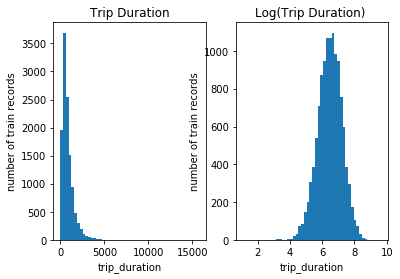

In [42]:
# split the screen into 2 part
fig, [ax1,ax2] = plt.subplots(ncols=2, nrows=1)  
# The distribution of travel time before transformation
ax1.hist(df['travel_time'],bins=50)
ax1.set_title("Trip Duration")
ax1.set_xlabel('trip_duration')  
ax1.set_ylabel('number of train records')  
# The distribution of travel time after log transformation
ax2.hist(np.log(df['travel_time'].values),bins=50)
ax2.set_title("Log(Trip Duration) ")
ax2.set_xlabel('trip_duration')  
ax2.set_ylabel('number of train records')  

### 1.3.3 make new variables from the old ones

We first found the fifty most frequent pickup locations, after rounding latitude and longitude. These locations have a heavy traffic with a higher probability, which may make the duration increase.

In [18]:
from math import radians, cos, sin, asin, sqrt
 
def haversine(lon1, lat1, lon2, lat2): # longitude1，latitude1，longitude2，latitude2 
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # transfered into radian
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378.137 # radius of earth.
    return c * r * 1000


query_freq=(
    """
    SELECT pk_lon, pk_lat, count(*) as freq
    FROM
    (SELECT *,
    TIMESTAMP_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
    EXTRACT (DATE FROM pickup_datetime) as date_of_year,
    EXTRACT (DAY FROM pickup_datetime) as day_of_year,
    EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
    EXTRACT (YEAR FROM pickup_datetime) as year_of_year,
    ROUND(pickup_longitude, 3) as pk_lon,
    ROUND(pickup_latitude, 3) as pk_lat
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016` 
    WHERE pickup_longitude is not NULL
    )
    GROUP by pk_lon, pk_lat
    ORDER by freq desc
    LIMIT 50
    """
)
df_taxi_freq = pd.io.gbq.read_gbq(query_freq, dialect='standard')
df_taxi_freq = df_taxi_freq.iloc[1:, ]

In [20]:
df_taxi_freq = pd.DataFrame(df_taxi_freq)
df_taxi_freq.sort_values(["pk_lon"],ascending=True)

,pk_lon,pk_lat,freq
44,-74.007,40.744,91806
23,-74.006,40.740,120273
22,-74.004,40.742,121425
41,-73.997,40.737,93451
19,-73.995,40.750,145001
21,-73.995,40.740,121561
45,-73.994,40.746,91566
1,-73.994,40.751,408195
39,-73.993,40.743,94014
17,-73.992,40.749,159191


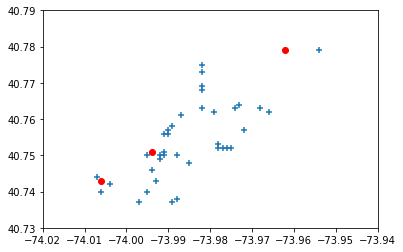

In [21]:
import matplotlib.pyplot as plt
plt.scatter(df_taxi_freq.pk_lon,df_taxi_freq.pk_lat, marker='+')
plt.scatter(-73.994, 40.751, color = "red", marker='o')
plt.scatter(-73.873, 40.774, color = "red", marker='o')
plt.scatter(-73.782, 40.645, color = "red", marker='o')
plt.scatter(-74.006, 40.743, color = "red", marker='o')
plt.scatter(-73.962, 40.779, color = "red", marker='o')
plt.xlim(-74.02, -73.94)
plt.ylim(40.73, 40.79)
plt.show()

After checking each pickup location on the map, we selected five representative locations manually as below.

**Pennsylvania Station (-73.994, 40.751)**

**LAG (-73.873, 40.774)**

**JFK (-73.782, 40.645)**

**Chelsea Market (-74.006, 40.743)**

**The Metropolitan Museum of Art (-73.962, 40.779)**

Then we computed the distance from all pickup and dropoff locations to these five frequent locations.

In [22]:
query_new_distance = (
    """
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );
    
SELECT
  pickup_latitude,
  pickup_longitude,
  TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) AS travel_time,
  TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
  TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
  TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
  TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
  TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
  TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
  TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
  TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
  TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
  TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND 
    dropoff_longitude IS NOT NULL AND 
    HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude)>0.1 
LIMIT 100;
"""
)
df_new_distance = pd.io.gbq.read_gbq(query_new_distance, dialect='standard')

In [23]:
df_new_distance.head()

,pickup_latitude,pickup_longitude,travel_time,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE
0,40.716515,-73.997177,1268,4.418841,6.906264,20.712325,5.763504,0.608425,3.838753,12.242890,19.784130,3.033336,7.543415
1,40.790916,-73.970963,2320,2.191740,11.048761,20.089462,1.769574,5.850803,4.837429,8.448441,22.704191,6.082353,1.522787
2,40.780960,-73.956718,1660,2.385728,11.865790,20.787853,1.451739,6.354675,4.571632,7.082102,21.076312,5.911821,0.494574
3,40.720814,-74.005386,1554,9.039546,10.888804,13.236205,9.033986,10.698197,3.486260,12.606369,20.608995,2.464213,7.420886
4,40.772034,-73.958992,1459,10.539460,0.053558,16.258185,11.752797,7.540909,3.758389,7.234765,20.517256,5.101856,0.813879


### 1.3.4 join other interesting data sets

In [1]:
def ifef(col):
    col = str(col)
    if col in Holiday_1:
        return  'common_holiday'
    if col in Holiday_2:
        return 'key_holiday'
    else:
        return 0

#### 1.3.4.1 weather and holiday

Weather data in BigQuery is as following:

In [24]:
query = (
    """
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` 
     WHERE stn='725053' AND CAST(year AS STRING)='2016'
     ORDER BY date_of_year2
    """
)
weather_df=pd.io.gbq.read_gbq(query,dialect='standard')
weather_df.head()


,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0
1,2016-01-02,2016,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0
2,2016-01-03,2016,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0
3,2016-01-04,2016,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0
4,2016-01-05,2016,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0


We created holiday data by ourself. It contains important holiday and unimportant holiday.

In [26]:
Holiday_2 = ['2016-01-01', '2016-01-18', '2016-02-14', '2016-03-27', '2016-03-28', '2016-07-04','2016-09-05', 
             '2016-10-31', '2016-11-24', '2016-11-25', '2016-12-24', '2016-12-25', '2016-12-31']
Holiday_1 = ['2016-01-24', '2016-02-02', '2016-02-09', '2016-03-13', '2016-03-17', '2016-03-25','2016-04-01', 
             '2016-04-22', '2016-05-05', '2016-05-08', '2016-05-15', '2016-05-16', '2016-05-21', '2016-05-30', 
             '2016-06-14', '2016-06-19', '2016-07-24', '2016-09-11', '2016-09-16', '2016-09-17', '2016-09-23',
             '2016-10-10', '2016-10-15', '2016-10-17', '2016-11-06', '2016-11-11', '2016-11-28', '2016-12-07']
    
weather_df['holiday'] = weather_df['date_of_year2'].apply(ifef)
df_holiday = pd.get_dummies(weather_df['holiday'])
weather_df_new = weather_df.join(df_holiday)
weather_df_new = weather_df_new.drop(['holiday',0] ,axis=1)
weather_df_new.head()

,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday
0,2016-01-01,2016,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1
1,2016-01-02,2016,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0
2,2016-01-03,2016,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0
3,2016-01-04,2016,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0,0,0
4,2016-01-05,2016,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0,0,0


#### 1.3.4.2 stock

We downloaded the S&P 500 data from YAHOO and upload it into BigQuery.

In [27]:
stock = (
    """
        SELECT CAST(Date AS STRING) as Date, Adj_Close
        FROM `predict-taxi-travel-time.GSPC.daily`
        ORDER BY Date
   """
)
stock=pd.io.gbq.read_gbq(stock,dialect='standard')

#### 1.3.4.3 merge

In [28]:

stock_logrtn = {'Date': stock[1:]["Date"].values  ,"logrtn" : numpy.log(stock[1:]["Adj_Close"].values/stock[0:-1]["Adj_Close"].values)*100 }
stock_logrtn = pd.DataFrame(stock_logrtn)
weather_stock = pd.merge(weather_df_new,
             stock_logrtn[["Date","logrtn"]],
             left_on = "date_of_year2",
             right_on = "Date",
             how = "left"
            )
weather_stock['logrtn'].fillna(0, inplace=True)
weather_stock = weather_stock.drop(['Date', 'year'], axis = 1)
# weather_stock.to_csv('../data/weather_stock.csv', index = False)
# `predict-taxi-travel-time.Weather_stock.2016`
weather_stock.head()

,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
0,2016-01-01,01,01,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.000000
1,2016-01-02,01,02,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0,0.000000
2,2016-01-03,01,03,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0,0.000000
3,2016-01-04,01,04,30.8,10.0,7.0,22.0,39.0,19.9,0.00,999.9,0,0,0,0,0,0,0,-1.542204
4,2016-01-05,01,05,18.4,10.0,6.2,22.0,36.0,10.9,0.00,999.9,0,0,0,0,0,0,0,0.201020


In [11]:
query_taxi_tidy = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );
     CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );

    SELECT 
        taxi.*,other.*
    FROM
    (
        SELECT
        EXTRACT (DATE FROM pickup_datetime) as date_of_year,
        TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
        trip_distance
        pickup_latitude,
        pickup_longitude,
        dropoff_latitude,
        dropoff_longitude,
        pickup_datetime,
        passenger_count,
        trip_distance,
        HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km,
        PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance,
        TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
        TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
        TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
        TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
        TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
        TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
        TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
        TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
        TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
        TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
        pickup_latitude > 40.21 AND pickup_latitude < 40.92 AND 
                dropoff_latitude > 40.21 AND dropoff_latitude < 40.92 AND 
                pickup_longitude > -74.68 AND pickup_longitude< -72.09 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -72.09 
        AND trip_distance > 0 AND passenger_count >0 
        AND  RAND() < 0.00001#233/(SELECT COUNT(*) FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`)
    ) taxi
    LEFT JOIN
    (
     SELECT *
     FROM `predict-taxi-travel-time.Weather_stock.2016`
    ) other
    ON CAST(taxi.date_of_year AS STRING)=CAST(other.date_of_year2 AS STRING)
    WHERE  EXTRACT(YEAR FROM taxi.pickup_datetime) = 2016 AND 
        taxi.distance_in_km>0.1 AND 
        taxi.travel_time > 0 AND 
        taxi.travel_time < 36000 
        AND (taxi.trip_distance*1000)/taxi.travel_time < 56 # remove outlier
    ORDER BY taxi.date_of_year
"""
)
taxi_tidy = pd.io.gbq.read_gbq(query_taxi_tidy, dialect='standard')
taxi_tidy.head()

,date_of_year,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,pickup_datetime,passenger_count,trip_distance,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
0,2016-01-01,267,0.60,-73.942963,40.828613,-73.942200,2016-01-01 01:40:02+00:00,2,0.60,0.782484,0.843959,9.656394,8.403229,24.442086,10.915889,5.755210,8.936390,7.906795,23.832256,10.210567,4.992858,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
1,2016-01-01,1105,5.07,-73.992241,40.703228,-74.010490,2016-01-01 20:34:40+00:00,1,5.07,6.145324,7.486650,5.483347,13.985173,20.300651,4.432621,9.351011,0.662253,10.208661,21.620114,1.921586,3.540962,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
2,2016-01-01,509,3.90,-73.952576,40.779881,-73.984932,2016-01-01 14:53:04+00:00,1,3.90,5.594068,7.609088,3.296475,9.434949,22.717753,4.462324,1.930746,8.812816,8.686389,24.508540,10.044215,5.048696,2016-01-01,1,1,40.4,10.0,6.5,22.9,48.0,37.0,0.03,999.9,0,0,0,0,0,0,1,0.0
3,2016-01-02,456,1.73,-73.975159,40.810066,-73.958618,2016-01-02 18:47:34+00:00,5,1.73,2.397211,3.343004,7.202204,8.237147,23.598376,8.446202,3.461444,4.871104,8.831420,23.075760,6.076014,1.861415,2016-01-02,1,2,35.8,10.0,6.0,18.1,42.1,32.0,0.00,999.9,0,0,0,0,0,0,0,0.0
4,2016-01-03,228,1.60,-73.960358,40.780018,-73.944649,2016-01-03 18:03:08+00:00,2,1.60,2.441140,3.373678,5.254618,6.061862,20.303126,6.597360,1.463377,3.061996,7.476215,19.821469,4.356190,1.944664,2016-01-03,1,3,38.4,10.0,6.4,21.0,45.0,32.0,0.00,999.9,0,0,0,0,0,0,0,0.0


## 1.4 Get data from BigQuery

In [27]:
query_final = (
"""
    CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
        ACOS(-1) * x / 180
    );
    CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
        111.045 * 180 * x / ACOS(-1)
    );
    CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
        CASE
            WHEN x <=1 and x>=-1 THEN ACOS(x)
            ELSE NULL
          END
    );
    CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        RADIANS_TO_KM(
            VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
            COS(RADIANS(long1) - RADIANS(long2)) +
            SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
    );
    CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
        HAVERSINE(lat1, long1, lat1, long2) +
        HAVERSINE(lat1, long1, lat2, long1)
    );
     CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.751, -73.994)
    );
    CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.774, -73.873)
    );
    CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.645, -73.782)
    );
    CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.743, -74.006)
    );
    CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
        HAVERSINE(lat, long, 40.779, -73.962)
    );
   
    SELECT 
        taxi.*,other.*
    FROM
    (
        SELECT 
            *, (trip_distance*1000)/(travel_time+1) AS speed
        FROM (
            SELECT
                EXTRACT (DATE FROM pickup_datetime) as date_of_year,
                pickup_datetime,
                TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
                trip_distance,
                pickup_latitude,
                pickup_longitude,
                dropoff_latitude,
                dropoff_longitude,
                passenger_count,
                HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km,
                PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance,
                TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
                TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
                TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
                TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
                TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
                TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
                TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
                TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
                TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
                TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
            FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL AND dropoff_longitude IS NOT NULL AND 
                pickup_latitude > 40.6 AND pickup_latitude < 40.91 AND 
                dropoff_latitude > 40.2 AND dropoff_latitude < 41 AND 
                pickup_longitude > -74.07 AND pickup_longitude< -73.69 AND 
                dropoff_longitude > -74.68 AND dropoff_longitude < -73.69
                AND  RAND() < 0.02 
        ) A
        WHERE 
          travel_time >= 0 AND 
          travel_time < 15000 AND trip_distance < 100
    ) taxi
    LEFT JOIN
    (
     SELECT *
     FROM `predict-taxi-travel-time.Weather_stock.2016`
    ) other
    ON CAST(taxi.date_of_year AS STRING)=CAST(other.date_of_year2 AS STRING)
    WHERE taxi.speed < 28 and taxi.distance_in_km >0 and taxi.Parallel_Distance > 0 
    #ORDER BY taxi.date_of_year
"""
)
final = pd.io.gbq.read_gbq(query_final, dialect='standard')

In [29]:
final.describe()

,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,speed,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn
count,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1.356701e+06,1356701.0,1356701.0,1.356701e+06,1.356701e+06,1.356701e+06
mean,8.386327e+02,2.959175e+00,4.075102e+01,-7.397357e+01,4.075182e+01,-7.397351e+01,1.663276e+00,3.435795e+00,4.439805e+00,3.610074e+00,9.593548e+00,2.034268e+01,4.248165e+00,4.444813e+00,3.296919e+00,9.562404e+00,2.019076e+01,3.936902e+00,4.313658e+00,3.266000e+00,3.516288e+00,1.551398e+01,5.107478e+01,3.197654e+01,3.376703e+01,2.973016e+02,6.203664e+01,4.225862e+01,8.960401e-02,9.447692e+02,4.006410e-02,2.786443e-01,6.911914e-02,0.0,0.0,8.403325e-02,2.551704e-02,1.964191e-02
std,6.592238e+02,3.603520e+00,2.787461e-02,3.776225e-02,3.202252e-02,3.499729e-02,1.313017e+00,3.892681e+00,5.177515e+00,3.356194e+00,2.608564e+00,2.855522e+00,3.420818e+00,3.406335e+00,3.430273e+00,2.508249e+00,3.274667e+00,3.524471e+00,3.416208e+00,1.730093e+00,1.679131e+00,8.702733e+00,1.536992e+01,1.487623e+02,1.663713e+02,4.402307e+02,1.646965e+01,1.470638e+01,2.298868e-01,2.272060e+02,1.961096e-01,4.483322e-01,2.536567e-01,0.0,0.0,2.774378e-01,1.576894e-01,8.423434e-01
min,0.000000e+00,0.000000e+00,4.060006e+01,-7.406906e+01,4.022587e+01,-7.465629e+01,0.000000e+00,9.480729e-05,1.896146e-04,4.377593e-03,2.124191e-03,2.764084e-03,2.153608e-03,7.529872e-03,3.792292e-04,1.896146e-04,1.228843e-03,2.243550e-03,1.038562e-03,0.000000e+00,1.000000e+00,1.000000e+00,6.900000e+00,1.700000e+00,1.200000e+00,1.400000e+01,2.190000e+01,-9.000000e-01,0.000000e+00,1.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,-3.658079e+00
25%,3.980000e+02,1.000000e+00,4.073739e+01,-7.399188e+01,4.073591e+01,-7.399131e+01,1.000000e+00,1.239910e+00,1.580261e+00,1.545734e+00,8.272160e+00,1.998784e+01,2.142665e+00,2.094030e+00,1.455814e+00,8.401160e+00,2.005540e+01,1.978523e+00,2.056098e+00,2.129496e+00,2.000000e+00,8.000000e+00,3.910000e+01,8.800000e+00,3.700000e+00,1.810000e+01,4.890000e+01,3.090000e+01,0.000000e+00,9.999000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,-1.652929e-01
50%,6.630000e+02,1.700000e+00,4.075418e+01,-7.398178e+01,4.075459e+01,-7.397975e+01,1.000000e+00,2.101568e+00,2.699785e+00,2.661809e+00,9.460287e+00,2.066644e+01,3.258597e+00,3.672647e+00,2.368923e+00,9.574938e+00,2.067573e+01,3.009835e+00,3.602028e+00,2.888087e+00,4.000000e+00,1.500000e+01,5.140000e+01,9.800000e+00,4.900000e+00,2.290000e+01,6.210000e+01,4.210000e+01,0.000000e+00,9.999000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.075000e+03,3.180000e+00,4.076841e+01,-7.396737e+01,4.076992e+01,-7.396303e+01,2.000000e+00,3.890057e+00,5.014845e+00,4.505865e+00,1.089007e+01,2.140032e+01,5.412305e+00,5.882879e+00,3.976280e+00,1.091217e+01,2.135638e+01,4.844647e+00,5.678365e+00,3.928571e+00,5.000000e+00,2.300000e+01,6.240000e+01,1.000000e+01,6.400000e+00,9.999000e+02,7.590000e+01,5.200000e+01,5.000000e-02,9.999000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.0,0.0,0.000000e+00,0.000000e+00,3.169611e-01
max,1.486500e+04,7.065000e+01,4.090969e+01,-7.369421e+01,4.099920e+01,-7.369005e+01,9.000000e+00,8.316042e+01,1.130776e+02,7.610156e+01,8.545146e+01,8.3

In [30]:
#final.to_csv('train_data_135_filtered.csv', index = False)
#final.to_csv('taxi_data.csv', index = False)
path = "taxi_data.csv"
taxi_data = load_data(path)

# 2. Exploratory Analysis

## 2.1 Analyze the features and their relationship with travel time 

### 2.1.1 Distribution of Trip Duration

The travel time is normal distributed after log transformation. We could add **log_travel_time** into the dataset.

Text(0,0.5,'number of train records')

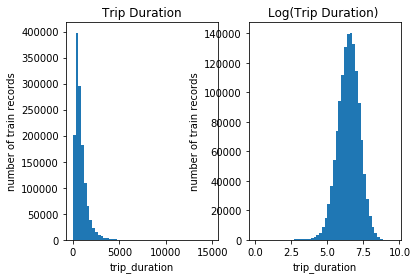

In [6]:
# split the screen into 2 part
fig, [ax1,ax2] = plt.subplots(ncols=2, nrows=1)  
# The distribution of travel time before transformation
ax1.hist(taxi_data['travel_time'],bins=50)
ax1.set_title("Trip Duration")
ax1.set_xlabel('trip_duration')  
ax1.set_ylabel('number of train records')  
# The distribution of travel time after log transformation
ax2.hist(np.log(taxi_data['travel_time'].values+1),bins=50)
ax2.set_title("Log(Trip Duration) ")
ax2.set_xlabel('trip_duration')  
ax2.set_ylabel('number of train records')  

In [8]:
# add log travel time to taxi data set
taxi_data.loc[:,'log_travel_time'] = np.log(taxi_data['travel_time'].values+1)

### 2.1.3 Pickup & Dropoff longtitude and latitude

The distribution of pickup & dropoff longtitude and latitude are normal distributed. This feature must be highly correlated with travel time.

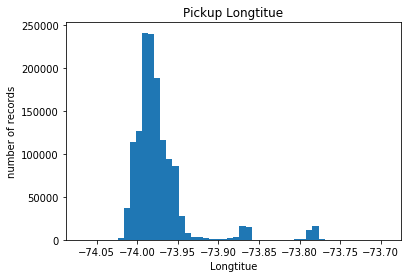

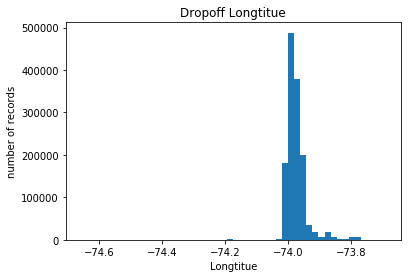

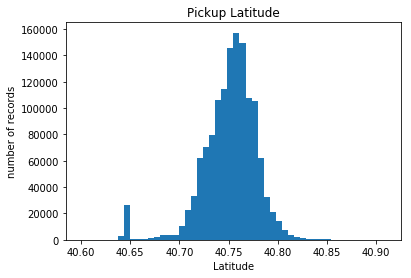

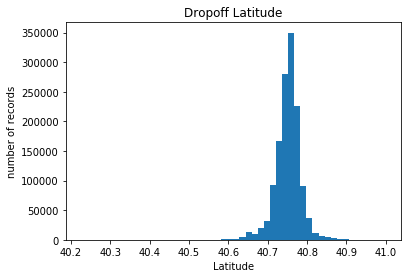

In [9]:
# pickup & drop off longtitude
plt.hist(taxi_data['pickup_longitude'],bins=50)
plt.title("Pickup Longtitue")
plt.xlabel('Longtitue')  
plt.ylabel('number of records')  
plt.show()
plt.hist(taxi_data['dropoff_longitude'],bins=50)
plt.xlabel('Longtitue')  
plt.ylabel('number of records')  
plt.title("Dropoff Longtitue")
plt.show()
# pickup & drop off latitude
plt.hist(taxi_data['pickup_latitude'],bins=50)
plt.xlabel('Latitude')  
plt.ylabel('number of records')  
plt.title("Pickup Latitude")
plt.show()
plt.hist(taxi_data['dropoff_latitude'],bins=50)
plt.xlabel('Latitude')  
plt.ylabel('number of records')  
plt.title("Dropoff Latitude")
plt.show()


### 2.1.3 Distance in km VS Travel Time

Text(0,0.5,'travel time')

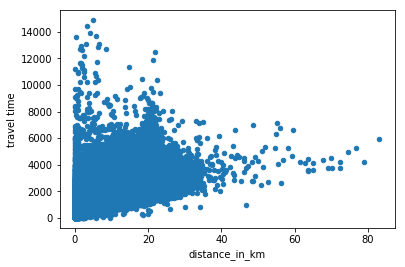

In [10]:
taxi_data.plot(x='distance_in_km',y='travel_time',kind='scatter')
plt.ylabel("travel time")

Some of the trip duration does not match its distance. Short distance but travel over 3 hour.

### 2.1.4 Travel Time and Pickup Time

In [11]:
# Extract Datetime, Month, Day, Weekday and Hour from pickup_datetime
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data.pickup_datetime)  
taxi_data.loc[:,'pickup_month'] =  taxi_data['pickup_datetime'].dt.month
taxi_data.loc[:,'pickup_day'] =  taxi_data['pickup_datetime'].dt.day
taxi_data.loc[:,'pickup_hour'] =  taxi_data['pickup_datetime'].dt.hour
taxi_data.loc[:,'pickup_weekday'] =  taxi_data['pickup_datetime'].dt.weekday+1

#### 2.1.4.1 Trip Durations with Months and Weekdays

Text(0.5,0,'Weekday')

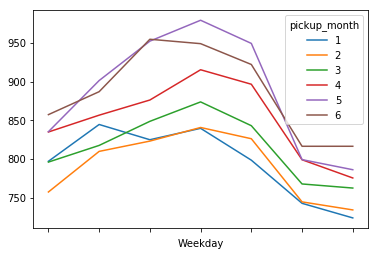

In [12]:
summary_wdays_avg_duration = pd.DataFrame(taxi_data.groupby(['pickup_month','pickup_weekday'])['travel_time'].mean())
summary_wdays_avg_duration = summary_wdays_avg_duration.unstack()
(summary_wdays_avg_duration.T).plot()
plt.xlabel('Weekday')

The travel time is different according to weekdays and month. We should add month and weekday as features in our model.

#### 2.1.4.2 Trip Durations with Hours and Weekdays

Text(0.5,0,'pickup_hour')

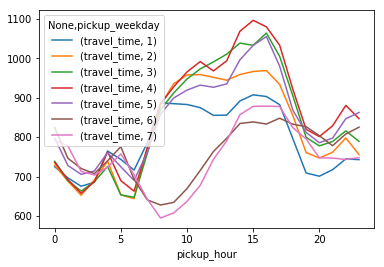

In [13]:
summary_hour_avg_duration = pd.DataFrame(taxi_data.groupby(['pickup_hour','pickup_weekday'])['travel_time'].mean())
summary_hour_avg_duration = summary_hour_avg_duration.unstack()
(summary_hour_avg_duration).plot()
plt.xlabel('pickup_hour')

Weekday and hour does effect the trip duration.

#### 2.1.4.3 Trip Durations with Day

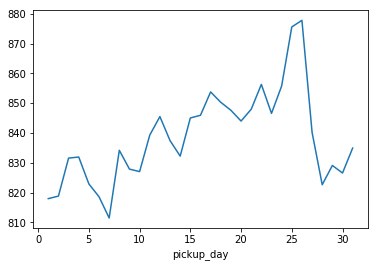

In [14]:
taxi_data.groupby(['pickup_day'])['travel_time'].mean().plot()

Trave date in one month also affect trip duration.

### 2.1.5  Travel Time and Passenger_count

Text(0.5,0,'passenger_count')

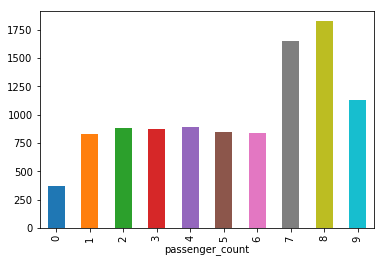

In [15]:
taxi_data.groupby(['passenger_count'])['travel_time'].mean().plot(kind = "bar")
plt.xlabel('passenger_count')

The passenger count seems does not influence trip duration. 

### 2.1.6 Total Number of Pickups 

It is a common sense that the trafic volumn will effect the duration of a trip. In this part, we will exam the total number of pickups as the representative of trafic volumn to see if it will changed by time.

#### 2.1.6.1 Total Number of Pickups by Month

Text(0.5,0,'Month')

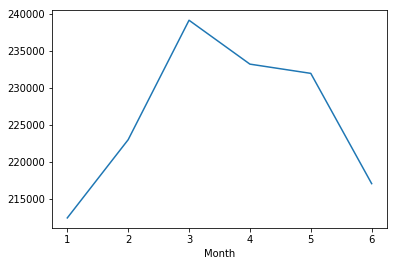

In [16]:
taxi_data.groupby(['pickup_month'])['travel_time'].count().plot()
plt.xlabel('Month')

Month may effect the trafic volumn that people trend to take taxi more during March to April. This maybe beacuse the weather is cold while don't have heavy snow in NYC.

#### 2.1.6.2 Total Number of Pickups by Day

Text(0.5,0,'Day')

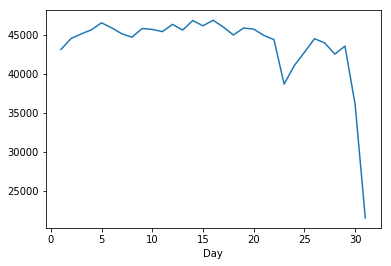

In [17]:
taxi_data.groupby(['pickup_day'])['travel_time'].count().plot()
plt.xlabel('Day')

The numbers of pickup seems to be same in the same day of a month. 

#### 2.1.6.3 Total Number of Pickups by Weekday

Text(0.5,0,'Weekday')

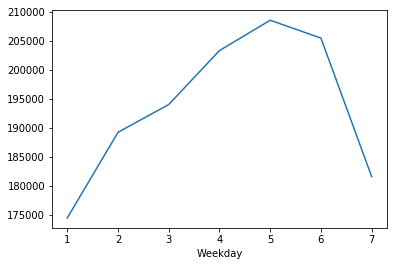

In [18]:
taxi_data.groupby(['pickup_weekday'])['travel_time'].count().plot()
plt.xlabel('Weekday')

It seems people tend to take more taxi at the end of a week.

#### 2.1.6.4 Total Number of Pickups by Hour

Text(0.5,0,'Hour')

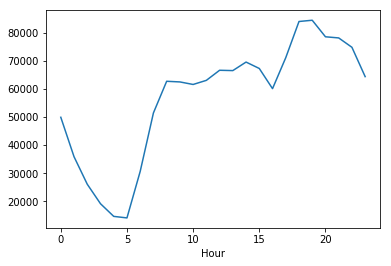

In [19]:
taxi_data.groupby(['pickup_hour'])['travel_time'].count().plot()
plt.xlabel('Hour')

Hours influence the trafic volumn and we should take this feature into consideration.

#### 2.1.6.5 Total Number of Pickups by Passenger_count

Text(0.5,0,'passenger_count')

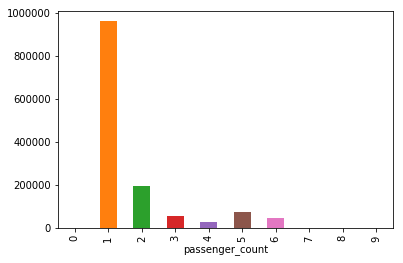

In [20]:
taxi_data.groupby(['passenger_count'])['travel_time'].count().plot(kind = "bar")
plt.xlabel('passenger_count')

In [22]:
taxi_data.groupby(['passenger_count'])['travel_time'].count()

passenger_count
0        37
1    961934
2    195388
3     55581
4     26529
5     72411
6     44812
7         2
8         5
9         2
Name: travel_time, dtype: int64

Most of people take taxi by themself. We may need futher analysis to see if this affect the travle time.

## 2.2 Correlations and chi-squared

### 2.2.1 Correlation matirx between continuous variables

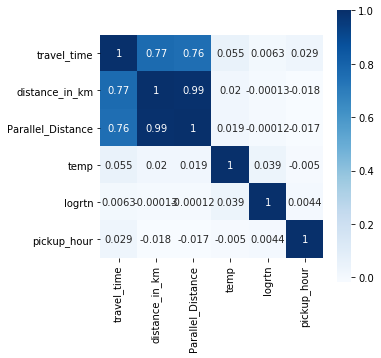

In [33]:
continus_var = taxi_data[["travel_time","distance_in_km","Parallel_Distance"
                          ,"temp","logrtn","pickup_hour"]]
import seaborn as sns
import matplotlib.pyplot as plt
# Corrlation plot
corr_continus = continus_var.corr()
plt.subplots(figsize=(5, 5)) 
sns.heatmap(corr_continus, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()

### 2.2.2 Chi-squre between categorical variables

In [35]:
import researchpy as rp
category_var=taxi_data[['common_holiday','key_holiday','passenger_count']]

#### 2.2.2.1 common_holiday with passenger_count

In [40]:
table, results = rp.crosstab(category_var['common_holiday'], 
                             category_var['passenger_count'], 
                             prop= 'col', test= 'chi-square')   
table

passenger_count                                                 \
                             0       1      2       3       4       5       6   
common_holiday                                                                  
0                         97.3   91.68   91.4   91.27   90.71   91.44   91.82   
1                          2.7    8.32    8.6    8.73    9.29    8.56    8.18   
All                      100.0  100.00  100.0  100.00  100.00  100.00  100.00   

                                            
                    7      8      9    All  
common_holiday                              
0               100.0  100.0  100.0   91.6  
1                 0.0    0.0    0.0    8.4  
All             100.0  100.0  100.0  100.0

In [41]:
results

,Chi-square test,results
0,Pearson Chi-square ( 9.0) =,61.1279
1,p-value =,0.0000
2,Cramer's V =,0.0067


#### 2.2.2.2 key_holiday with passenger_count

In [43]:
table, results = rp.crosstab(category_var['key_holiday'], category_var['passenger_count'], 
                             prop= 'col', test= 'chi-square')
    
table

passenger_count                                                 \
                          0       1       2       3       4      5       6   
key_holiday                                                                  
0                     94.59   97.56   97.14   97.07   96.77   97.4   97.36   
1                      5.41    2.44    2.86    2.93    3.23    2.6    2.64   
All                  100.00  100.00  100.00  100.00  100.00  100.0  100.00   

                                          
                 7      8      9     All  
key_holiday                               
0            100.0  100.0  100.0   97.45  
1              0.0    0.0    0.0    2.55  
All          100.0  100.0  100.0  100.00

In [45]:
results

,Chi-square test,results
0,Pearson Chi-square ( 9.0) =,208.9935
1,p-value =,0.0000
2,Cramer's V =,0.0124


# 3. Model Comparison

# Function

In [2]:
# define my own custom loss function
def rmsle_loss(y_pred, y_true): 
    y_pred = tf.convert_to_tensor(y_pred, np.float32)
    y_true = tf.convert_to_tensor(y_true, np.float32)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

# define my own custom score function
def rmsle(y_true, y_pred):
    y_pred = list(map(lambda x:x if x>0 else 0.000001, y_pred))
    first_log = np.log(y_pred)
    second_log = np.log(y_true)
    return np.sqrt(np.mean(np.square(first_log - second_log)))
rmsle_socre = make_scorer(rmsle, greater_is_better=False)

def create_model(input_dim = 73, nodes_num=[256]):
    n = len(nodes_num)
    # create model
    model = Sequential()
    for i in range(n):
        if i == 0:
            model.add(Dense(nodes_num[i], input_dim=input_dim, activation='relu', kernel_initializer='normal'))
        else :
            model.add(Dense(nodes_num[i], activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss=losses.mean_squared_logarithmic_error, optimizer='adam', metrics=[rmsle_loss])
    return model

# using GridSearchCv to find proper parameters
def My_GridSearchCV(grid_params, X, Y):
    # create model
    model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=50, verbose=0)
    grid = GridSearchCV(estimator=model, param_grid=grid_params, cv=3, scoring = rmsle_socre, verbose=10)
    grid_result = grid.fit(X, Y)
    return grid_result

# summarize grid reseach cv results
def Summary_GridResult(grid_result):
    # grid_result.cv_results_
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, std, param in zip(means, stds, params):
        print("mean: %f, std: %f, with: %r" % (mean, std, param))    

# Prepare data
def prepare_data(data):
    # drop useless columns
    dataset = data.drop(['date_of_year', 'date_of_year2', 'mo','da','trip_distance','speed'], axis = 1)
    dataset.loc[dataset.Parallel_Distance.isnull(), 'Parallel_Distance'] = dataset[dataset['Parallel_Distance'].isnull()]['distance_in_km'].values
    return dataset

# extracted new two varaibles: hour and weekday
def Extract_Time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    # as datetime cannot be used directly, drop it
    data = data.drop(['pickup_datetime'], axis = 1)
    return(data)

# Transfrom categorical variables into dummy variables using one hot encode
def Dummy_One_Hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_') 
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_hour','pickup_weekday'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  passenger_count, hour, dow], axis=1)
    return(data)

# Split input and output
def Split_x_y(data):
    X = data.values[:, 1:dataset.shape[1]]
    Y = data.values[:, 0]
    return X, Y


def load_data(path) :
    data = pd.read_csv(path) 
    # basic data cleaning. drop useless columns
    data.loc[data.Parallel_Distance.isnull(), 'Parallel_Distance'] = data[data['Parallel_Distance'].isnull()]['distance_in_km'].values
    data = data.drop(['date_of_year','date_of_year2','mo','da'], axis=1)
    return (data)

def extract_time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_day'] =  data['pickup_datetime'].dt.day
    data.loc[:,'pickup_month'] =  data['pickup_datetime'].dt.month
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    data.loc[:,'log_travel_time'] =  np.log(data['travel_time'].values+1)
    
    return(data)

def add_avg_speed(data, group,name) :
    avg_speed = pd.DataFrame(data.groupby(group)['speed'].mean())
    avg_speed = avg_speed_h.rename(columns={'speed':name})
    return (avg_speed)

# Transfrom categorical variables into dummy variables using one hot encode
def dummy_one_hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    cluster_pickup = pd.get_dummies(data['pickup_cluster'], prefix='p', prefix_sep='_')  
    cluster_dropoff = pd.get_dummies(data['dropoff_cluster'], prefix='d', prefix_sep='_')  
    #month = pd.get_dummies(data['pickup_month'], prefix='m', prefix_sep='_')   
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime', 
                              'trip_distance','travel_time','speed'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          cluster_pickup,
                          cluster_dropoff,
                          dom, hour, dow], axis=1)
    
    return(data)

def col_consistant(data,cluster_num):
    cluster = range(1,cluster_num,1)
    cluster_dummy_p = pd.get_dummies(cluster, prefix='p', prefix_sep='_')  
    cluster_dummy_d = pd.get_dummies(cluster, prefix='d', prefix_sep='_')  
    cluster_dummy = pd.concat([cluster_dummy_p, cluster_dummy_d], axis=1)
    passenger = range(1,9,1)
    passenger_dummy = pd.get_dummies(passenger, prefix='pc', prefix_sep='_') 
    whole = pd.concat([cluster_dummy, passenger_dummy], axis=1)
    # let two dataset has the same columns
    larger_colnames = whole.columns.values.tolist()
    smaller_colnames = data.columns.values.tolist()
    ret = list(set(larger_colnames).difference(set(smaller_colnames)))
    d = pd.DataFrame(0, index=np.arange(data.shape[0]), columns=ret)
    data = pd.concat([data,  
                          d], axis=1)
    return(data)

def dummy_one_hot1 (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime', 
                              'trip_distance','log_travel_time','speed'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          dom, hour, dow], axis=1)
    
    return(data)

def col_consistant1(data):
   
    passenger = range(1,9,1)
    passenger_dummy = pd.get_dummies(passenger, prefix='pc', prefix_sep='_') 
    # let two dataset has the same columns
    larger_colnames = passenger_dummy.columns.values.tolist()
    smaller_colnames = data.columns.values.tolist()
    ret = list(set(larger_colnames).difference(set(smaller_colnames)))
    d = pd.DataFrame(0, index=np.arange(data.shape[0]), columns=ret)
    data = pd.concat([data,  
                          d], axis=1)
    return(data)

def modelcompare(xgb,bp,dtree,lasso):
    rmsle = pd.DataFrame([np.sqrt(mean_squared_log_error(xgb["log_travel_time"], xgb["predictions-XGB"])),
          np.sqrt(mean_squared_log_error(bp["true_value"], bp["predictions-BPNN"])),
          np.sqrt(mean_squared_log_error(dtree["travel_time"], dtree["predictions-decistion tree"])),
          np.sqrt(mean_squared_log_error(lasso["travel_time"], lasso["predictions-lasso"]))])
    rmse = pd.DataFrame([np.sqrt(mean_squared_error(xgb["log_travel_time"], xgb["predictions-XGB"])),
          np.sqrt(mean_squared_error(bp["true_value"], bp["predictions-BPNN"])),
          np.sqrt(mean_squared_error(dtree["travel_time"], dtree["predictions-decistion tree"])),
          np.sqrt(mean_squared_error(lasso["travel_time"], lasso["predictions-lasso"]))])
    r2 = pd.DataFrame([r2_score(xgb["log_travel_time"], xgb["predictions-XGB"]),
          r2_score(bp["true_value"], bp["predictions-BPNN"]),
          r2_score(dtree["travel_time"], dtree["predictions-decistion tree"]),
          r2_score(lasso["travel_time"], lasso["predictions-lasso"])])
    row = pd.DataFrame(["XGB","BP NN","Decision Tree","Lasso"])
    result_compare = pd.concat([row,rmsle,rmse,r2],axis=1)
    result_compare.columns = ["Model","RMSLE","RMSE","R2"]
    return(result_compare)

# Step1 Split data into training and testing data

We split the taxi data to traning and testing. We would use traning data to bulid 4 different models and make predictions on testing data to make comparision between models. We would calculate the RMSLE, RMSE, R2 between the real value and predict value.

In [4]:
training, testing  = train_test_split(taxi_data,test_size=0.2, random_state=535)
training = training.reset_index()
testing = testing.reset_index()

# Step2 Using K-Means to cluster the pickup & dropoff locations

We will use **MiniBatchKMeans** function to cluster pickup&dropoff location into 500 categories.

In [5]:
coords = np.vstack((training[['pickup_latitude', 'pickup_longitude']].values,  
                    training[['dropoff_latitude', 'dropoff_longitude']].values))
# cluster pickup&dropoff location into 500 categories
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=10000).fit(coords)  
# calculte cluster in training
training.loc[:, 'pickup_cluster'] = kmeans.predict(training[['pickup_latitude', 'pickup_longitude']])  
training.loc[:, 'dropoff_cluster'] = kmeans.predict(training[['dropoff_latitude', 'dropoff_longitude']])  
# calculte cluster in testing
testing.loc[:, 'pickup_cluster'] = kmeans.predict(testing[['pickup_latitude', 'pickup_longitude']])  
testing.loc[:, 'dropoff_cluster'] = kmeans.predict(testing[['dropoff_latitude', 'dropoff_longitude']])  

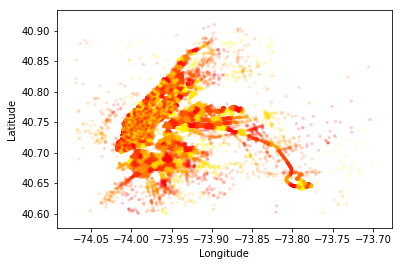

In [6]:
# graph
plt.scatter(training.pickup_longitude.values, training.pickup_latitude.values, s=10, lw=0,  
           c=training.pickup_cluster.values, cmap='autumn', alpha=0.2)
city_long_border = (-74.03, -73.75)  
city_lat_border = (40.63, 40.85)  
plt.xlim(city_long_border)  
plt.ylim(city_lat_border)  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.show()  

# Step3 Add more features into the model

## 3.1 Add **time** as new features into the model

In [10]:
# Extract time in training dataset
training_features = extract_time(training)
# Extract time in testing dataset
testing_features = extract_time(testing)
testing_features.head()

,index,pickup_datetime,travel_time,trip_distance,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,...,common_holiday,key_holiday,logrtn,pickup_cluster,dropoff_cluster,pickup_day,pickup_month,pickup_hour,pickup_weekday,log_travel_time
0,197614,2016-05-16 21:12:09,908,1.98,40.768913,-73.985291,40.750263,-74.004883,1,2.646645,...,1,0,0.974898,183,40,16,5,21,1,6.812345
1,422527,2016-02-23 08:07:46,631,1.23,40.776291,-73.961807,40.761127,-73.971237,1,1.861236,...,0,0,-1.253258,478,334,23,2,8,2,6.448889
2,25550,2016-01-23 11:11:56,895,1.80,40.724461,-73.993164,40.745010,-73.978615,1,2.589596,...,0,0,0.000000,267,260,23,1,11,6,6.797940
3,293367,2016-06-27 13:31:47,520,1.10,40.744225,-73.984749,40.755836,-73.983467,2,1.293948,...,0,0,-1.826225,312,86,27,6,13,1,6.255750
4,295712,2016-06-28 22:29:51,587,2.10,40.734615,-74.004715,40.709133,-74.005531,1,2.830502,...,0,0,1.761412,146,71,28,6,22,2,6.376727


# Step4 Convert categorical variables into dummy variables using one hot encode

In [13]:
# Transfrom categorical variables into dummy variables using one hot encode
# training dataset
training_dummy = dummy_one_hot(training_features)
# testing dataset
testing_dummy = dummy_one_hot(testing_features)


In [12]:
# let testing data and training data has the same columns 
training_final = col_consistant(training_dummy,500).drop(['index'],axis=1)
testing_final = col_consistant(testing_dummy,500).drop(['index'],axis=1)
testing_final = testing_final[training_final.columns.values.tolist()]
testing_final.head()


,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,p_10,p_41,p_233
0,2.646645,3.719166,0.919144,11.401331,22.107418,0.812001,4.815708,2.119784,9.460135,21.958553,...,1,0,0,0,0,0,0,0,0,0
1,1.861236,2.476971,2.220561,8.384646,20.495702,3.550141,2.131273,3.901086,7.472309,21.014789,...,0,1,0,0,0,0,0,0,0,0
2,2.589596,3.505980,1.455195,9.448735,19.933859,2.314745,4.024772,2.947907,11.508667,19.850284,...,0,0,0,0,0,1,0,0,0,0
3,1.293948,1.397263,1.036087,9.507240,20.955943,2.371714,3.142566,1.082488,9.964036,20.317391,...,1,0,0,0,0,0,0,0,0,0
4,2.830502,2.898385,4.749289,13.274703,20.126977,3.760951,8.579335,2.030521,11.911581,21.229410,...,0,1,0,0,0,0,0,0,0,0


In [14]:
training_final.head()

,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,...,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7,p_10,p_41,p_233
0,0.835619,1.093035,3.681307,8.729913,22.290366,4.933625,1.235488,3.129407,9.475959,22.651269,...,0,0,0,0,0,1,0,0,0,0
1,2.331261,2.432333,2.576834,12.283998,21.162931,1.448458,6.628851,0.987388,11.453930,22.208728,...,1,0,0,0,0,0,0,0,0,0
2,3.269653,4.191860,4.059302,13.126579,20.704680,2.976832,8.014222,0.796910,10.859930,21.095372,...,0,0,0,0,0,0,1,0,0,0
3,1.336802,1.696601,0.131764,10.592475,21.384072,1.217170,4.243354,1.463875,11.383583,21.096991,...,0,0,0,0,0,0,1,0,0,0
4,14.672341,15.174844,8.005290,12.677623,15.850484,7.590254,10.692123,7.720675,8.417529,23.943329,...,1,0,0,0,0,0,0,0,0,0


# Step5 Build model

## 5.1 Linear model - LASSO

### 5.1.1 Feature Selection

Delete some features that seems like do not have linear association with trip duration

In [16]:
taxi_data_linear = training.drop(['speed', 'pickup_datetime', 
                                'trip_distance', 'drop_CSMK_DISTANCE', 'drop_MMOA_DISTANCE',                           
       'pick_CSMK_DISTANCE', 'pick_LAG_DISTANCE', 'drop_LAG_DISTANCE',
       'pick_MMOA_DISTANCE',  'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
       'dropoff_longitude', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'hail', 'thunder',
        'pick_PEN_DISTANCE', 'drop_PEN_DISTANCE','pickup_cluster','dropoff_cluster','index','pickup_day',
       'pickup_month', 'pickup_hour', 'pickup_weekday','log_travel_time'] ,axis=1)
test_linear = testing_features.drop(['speed', 'pickup_datetime', 
                                'trip_distance', 'drop_CSMK_DISTANCE', 'drop_MMOA_DISTANCE',                           
       'pick_CSMK_DISTANCE', 'pick_LAG_DISTANCE', 'drop_LAG_DISTANCE',
       'pick_MMOA_DISTANCE',  'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 
       'dropoff_longitude', 'rain_drizzle', 'fog', 'snow_ice_pellets', 'hail', 'thunder',
        'pick_PEN_DISTANCE', 'drop_PEN_DISTANCE','pickup_cluster','dropoff_cluster','index','pickup_day',
       'pickup_month', 'pickup_hour', 'pickup_weekday','log_travel_time','travel_time'] ,axis=1)
test_linear_y = testing_features['travel_time']
taxi_data_linear.columns.values

array(['travel_time', 'passenger_count', 'distance_in_km',
       'Parallel_Distance', 'drop_JFK_DISTANCE', 'pick_JFK_DISTANCE',
       'temp', 'visib', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp',
       'common_holiday', 'key_holiday', 'logrtn'], dtype=object)

### 5.1.2 Split the whole data into training and testing, and scale

since there are still many features left, we want to use Lasso model to fit the data and do further feature selection

first, split the whole data into training part and test part and scale them since we will use Lasso model later

In [17]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import pylab


Y = taxi_data_linear.travel_time
X = taxi_data_linear.drop(columns = 'travel_time', axis = 1)
#X = X.assign(intercept = np.repeat(1, len(X)))

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state =535)

X_scaled_train = (X_train-np.mean(X_train))/np.std(X_train)
y_scaled_train = Y_train - np.mean(Y_train)
X_scaled_test = (X_test-np.mean(X_train))/np.std(X_train)
y_scaled_test = Y_test - np.mean(Y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [21]:
X_scaled_train = pd.DataFrame(X_scaled_train)
y_scaled_train = pd.DataFrame(y_scaled_train)
X_scaled_train.columns = X_train.columns
X_scaled_train.head()
#taxi_data_train = X_scaled_train.join(y_scaled_train)
taxi_data_train = pd.merge(X_scaled_train, y_scaled_train, left_index=True, right_index=True)
y_scaled = taxi_data_train.travel_time
X_scaled = taxi_data_train.drop(columns = 'travel_time', axis = 1)

### 5.1.3 Tune the parameter

tune the penalty parameter's value for Lasso model to select the most properly one

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

alphas = [0.1, 1, 5]
lasso = Lasso(max_iter=10000, normalize=True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_scaled, y_scaled)
    coefs.append(lasso.coef_)

#cv_params = {'alpha': [0.1, 1]} # try many times to get the best "n_estimators"
#model = Lasso(fit_intercept=False)
#optimized_Lasso = GridSearchCV(estimator=model, param_grid=cv_params
#                            , scoring='r2', cv=3, verbose=3, n_jobs=-1)
lassocv = LassoCV(alphas=None, cv=10, max_iter=100000, normalize=True)
lassocv.fit(X_scaled_train, y_scaled_train)
lasso.set_params(alpha=lassocv.alpha_)
print("Alpha=", lassocv.alpha_)
lasso.fit(X_scaled_train, y_scaled_train)
print("mse = ",mean_squared_error(y_scaled_test, lasso.predict(X_scaled_test)))
print("best model coefficients:")
pd.Series(lasso.coef_, index=X.columns)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Alpha= 0.0008588989822385325
mse =  174176.46758068373
best model coefficients:


passenger_count        4.543800
distance_in_km       886.904354
Parallel_Distance   -373.409167
drop_JFK_DISTANCE    -14.282495
pick_JFK_DISTANCE     27.325031
temp                  16.991780
visib                 -9.943898
wdsp                  15.458964
gust                   6.080579
max                   -2.690771
min                    9.352741
prcp                  -7.345797
sndp                 -10.808866
common_holiday        -9.450079
key_holiday          -15.287903
logrtn                 4.411021
dtype: float64

### 5.1.4 Fit Model and Predict

#### 5.1.4.1 Fit model

In [66]:
L_model = Lasso(alpha = 0.0008588989822385325, fit_intercept=False)
L_model.fit(X_scaled_train, y_scaled_train)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso(alpha=0.0008588989822385325, copy_X=True, fit_intercept=False,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

#### 5.1.4.2 Predict
unscale the data so that the prediction is reasonable and put the test y and prediction y together

In [67]:
test_linear_scaled = (test_linear-np.mean(X_train))/np.std(X_train)

In [68]:
y_train_pred = L_model.predict(test_linear_scaled) + np.mean(Y_train)
y_train_pred = pd.DataFrame(y_train_pred)
test_linear_y = pd.DataFrame(test_linear_y)
y_train_pred.columns = ['travel_time_prediction']

y_lasso = pd.merge(test_linear_y, y_train_pred, left_index=True, right_index=True)
np.sqrt(mean_squared_log_error(test_linear_y.values, y_train_pred.values))

0.5321438686510488

In [84]:
y_lasso.to_csv('y_lasso.csv', index = False)

### 5.1.5 Feature Importance

([<matplotlib.axis.YTick at 0x1a1bdf5cf8>,
 <a list of 16 Text yticklabel objects>)

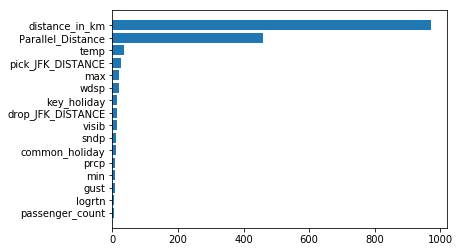

In [83]:
import matplotlib.pyplot as plt
y = abs(L_model.coef_)
coef_ = pd.DataFrame(y)
coef_.columns = ['value']
coef_['coef'] =  X_test.columns
coef_ = coef_.sort_values(ascending=True, by=['value'])

x0 = np.linspace(1,16,16)

plt.barh(x0, coef_.value)
plt.yticks(x0, coef_.coef)

## 5.2 Decision Tree

### 5.2.1 Test train split and using 3 fold cross validation

In [11]:
# Feature selection
# training dataset
training_dummy1 = dummy_one_hot1(training_features)
# testing dataset
testing_dummy1 = dummy_one_hot1(testing_features)
testing_dummy1.head()
# let testing data and training data has the same columns 
training_final1 = col_consistant1(training_dummy1).drop(['index'],axis=1)
testing_final1 = col_consistant1(testing_dummy1).drop(['index'],axis=1)
testing_final1 = testing_final1[training_final1.columns.values.tolist()]

In [12]:
y_train=training_final1['travel_time']
X_train=training_final1.drop('travel_time',1)

X_test = testing_final1.drop('travel_time',1)
y_test = testing_final1['travel_time']
kf = KFold(n_splits=3, shuffle=True, random_state=1111)
kf

KFold(n_splits=3, random_state=1111, shuffle=True)

### 5.2.2 Regularization, Grid Search and tuning parameter

In [13]:
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.subtract(np.log1p(y_true), np.log1p(y_pred)))))

1.I first try to tuning each parameter individually and get best sample split is 0.1, best depth is 15. best sample_leaf is 5
best max_features is 90.

2.After many trials of different parameters, I choose only to tune max_depth and use default parameters since this will give me a lower msle score.  This parameter indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data.

3.I also tried lots of different parameters and a detailed grid for all parameters are here:


In [ ]:
model = DecisionTreeRegressor()
param_grid = {
    'max_depth': [11, 13, 15, 17, 21, 23] ,
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [0.1,0.2],
    'max_features':  [10,20,30,40,50,60,70,80,90]
}


**The result was:**

**RMSLE = 0.44 for max depth = 11, min_samples_leaf = 3, min_sample_split = 0.1**


Use 3 fold cross validation with grid search method to tune parameters

In [14]:
model = DecisionTreeRegressor()
param_grid = {
    'max_depth' : [11, 13, 15, 17, 21, 23]    
}
search_cv = GridSearchCV(model, param_grid, scoring=make_scorer(rmsle, greater_is_better=False),
                   cv=kf, verbose=3)

search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=11 ....................................................
[CV] .......... max_depth=11, score=-0.4446616010889671, total=  10.2s
[CV] max_depth=11 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.6s remaining:    0.0s


[CV] .......... max_depth=11, score=-0.4470023943712959, total=   9.5s
[CV] max_depth=11 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   20.5s remaining:    0.0s


[CV] ......... max_depth=11, score=-0.45031179040679803, total=   9.4s
[CV] max_depth=13 ....................................................
[CV] ......... max_depth=13, score=-0.44143186875832935, total=  11.3s
[CV] max_depth=13 ....................................................
[CV] ......... max_depth=13, score=-0.44245580843743754, total=  11.8s
[CV] max_depth=13 ....................................................
[CV] .......... max_depth=13, score=-0.4467947486930407, total=  11.4s
[CV] max_depth=15 ....................................................
[CV] ......... max_depth=15, score=-0.44138310881268006, total=  12.2s
[CV] max_depth=15 ....................................................
[CV] .......... max_depth=15, score=-0.4411892762434818, total=  12.5s
[CV] max_depth=15 ....................................................
[CV] .......... max_depth=15, score=-0.4476208563177184, total=  12.5s
[CV] max_depth=17 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.1min finished


GridSearchCV(cv=KFold(n_splits=3, random_state=1111, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [11, 13, 15, 17, 21, 23]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=3)

### 5.2.3 Performance, importance plot

0.43561827382082646


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,12.340664,0.171208,-0.443398,-0.392625,15,{'max_depth': 15},1,-0.441383,-0.392677,-0.441189,-0.394512,-0.447621,-0.390686,0.144850,0.002861,0.002987,0.001562
1,11.443396,0.168549,-0.443561,-0.414891,13,{'max_depth': 13},2,-0.441432,-0.415452,-0.442456,-0.416160,-0.446795,-0.413061,0.203501,0.007464,0.002325,0.001326
0,9.686428,0.151262,-0.447325,-0.433721,11,{'max_depth': 11},3,-0.444662,-0.434732,-0.447002,-0.433790,-0.450312,-0.432642,0.361930,0.003848,0.002318,0.000855
3,13.382877,0.185837,-0.447863,-0.366018,17,{'max_depth': 17},4,-0.445023,-0.365747,-0.445879,-0.369758,-0.452686,-0.362550,0.149324,0.016933,0.003428,0.002949
4,15.877538,0.212764,-0.466891,-0.302915,21,{'max_depth': 21},5,-0.464979,-0.301014,-0.465166,-0.307446,-0.470526,-0.300285,0.214064,0.016171,0.002572,0.003217


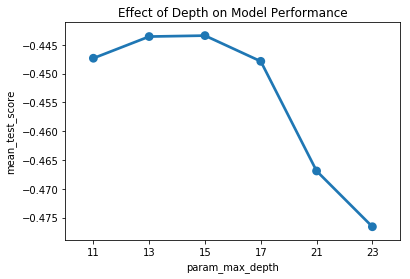

In [18]:
rmsle = {}
for i in (1,2,3,4,5):
    def rmsle1(y, y0):
        return np.sqrt(np.mean(np.square(np.log1p(y) - np.log1p(y0))))
    
    y_pred = search_cv.best_estimator_.predict(X_test)
    rmsle[i] = rmsle1(y_pred,y_test)
print(np.array(list(rmsle.values())).mean())

df1 = pd.DataFrame(data=search_cv.cv_results_)
df1
fig,ax = plt.subplots()
sns.pointplot(data=df1[['mean_test_score',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',ax=ax)
ax.set(title="Effect of Depth on Model Performance")
results = pd.DataFrame(search_cv.cv_results_).sort_values(by='mean_test_score', ascending=False)
results.head()

In [16]:
iris = load_iris()
clf = tree.DecisionTreeClassifier(max_depth=15)
clf = clf.fit(X_train,y_train)
fidt = pd.Series(clf.feature_importances_)

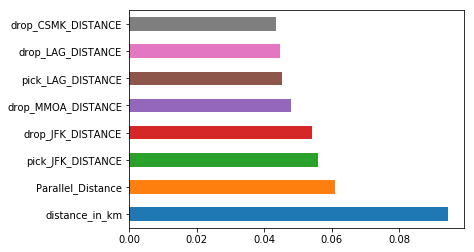

0    0.094425
1    0.061055
9    0.055773
4    0.054085
6    0.047961
8    0.045147
3    0.044644
5    0.043508
dtype: float64


In [25]:
colname = ['distance_in_km','Parallel_Distance','pick_JFK_DISTANCE','drop_JFK_DISTANCE',
 'drop_MMOA_DISTANCE','pick_LAG_DISTANCE','drop_LAG_DISTANCE','drop_CSMK_DISTANCE']
fidt.nlargest(8).plot(kind='barh')
plt.yticks(range(0,8),colname)

plt.show()
print(fidt.nlargest(8))

### 5.2.4 Prediction


In [26]:
new_series = pd.Series(y_pred)
dtree=pd.concat([y_test.reset_index(drop=True), new_series.reset_index(drop=True)], axis=1)
#test.to_csv("C:/Users/59381/Desktop/test.csv", index = False)

## 5.3 XGBoost

**Introdutcion to XGBoost (eXtreme Gradient Boosting)**

XGBoost is an advanced implementation of gradient boosting algorithm. The original author is Tianqi Chen. XGBoost has many parameters and  parameter tuning is complex.

### 5.3.1 Split data into train and test data again

We split the data used to build model again to seperate traning data and validation data.

In [15]:
train, test  = train_test_split(training_final,test_size=0.8, random_state=535)

In [16]:
# train and test dataset for the XGBoost model
X_train = train.drop(['log_travel_time'], axis=1)  
Y_train = train["log_travel_time"]  
X_test = test.drop(['log_travel_time'], axis=1)  
Y_test = test["log_travel_time"]

Y_test = Y_test.reset_index().drop('index',axis = 1)  
Y_train = Y_train.reset_index().drop('index',axis = 1)  
# Testing dataset
X_testing = testing_final.drop(['log_travel_time'], axis=1) 
Y_testing = testing_final["log_travel_time"]  
Y_testing = Y_testing.reset_index().drop('index',axis = 1)  

### 5.3.2 Transfrom training data and testing data into the format that suit for XGBoost 

In [17]:
# Transfrom training data and testing data into the format that suit for XGBoost 
dtrain = xgb.DMatrix(X_train, label=Y_train)  
dvalid = xgb.DMatrix(X_test, label=Y_test)  
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]  
dtest = xgb.DMatrix(X_testing)

### 5.3.3 Tune the model

The overall parameters have been divided into 3 categories by authors:
<br>&emsp;&emsp;*General Parameters:* Guide the overall functioning
<br>&emsp;&emsp;&emsp; 1. booster: It has two options: "gbtree" or "gblinear". We will set it as "gbtree".
<br>&emsp;&emsp;&emsp; 2. slient: It could be 0 or 1. If it is 1, there would be no running message. We will set it as 1.
<br>&emsp;&emsp;*Booster Parameters:* Guide the individual booster (tree/regression) at each step
<br>&emsp;&emsp;&emsp; 1. eta: Step size shrinkage used in update to prevents overfitting. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 2. max_depth: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 3. min_child_weight: Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit. We will tune this parameter later.
<br>&emsp;&emsp;&emsp; 4. subsample: Subsample ratio of the training instances. This will prevent overfitting We will tune this parameter later.
<br>&emsp;&emsp;*Learning Task Parameters:* Guide the optimization performed
<br>&emsp;&emsp;&emsp; 1. objective: we ues "reg:linear"
<br>&emsp;&emsp;&emsp; 2. eval_metric: we ues "rmse": root mean square error.

We ues some parameters by its default value and will focus on turing 4 booster paramters: *n_estimators*, *eta*, *max_depth*, *min_child_weight*, *subsample* . First of all, beacuse our dataset is super large and the computation ability in laptop is limited. We will first ues a small dataset from training data and find the best parameter using **3 fold cross validation** in the small dataset.

#### 5.3.3.1 Tune *n_eatinators* using **GridSearchCV**

As we could see, we first used **GridSearchCV** to perform 3 fold crossing validation to find the best *n_estimators*. The speed is quite slow using GridSearchCV function. It took over 25 minutes when *n_estimators* from 500 to 800. So we will use **xgb.cv** to tune other parameters on a smaller sample size and then using **GridSearchCV** to get more accurate results.

In [59]:
# split another smaller training dataset to turn the model
training_t, testing_t  = train_test_split(train,test_size=0.6)
X_train_t = training_t.drop(['log_travel_time'], axis=1)  
Y_train_t = training_t["log_travel_time"]  
X_test_t = testing_t.drop(['log_travel_time'], axis=1)  
Y_test_t = testing_t["log_travel_time"]

Y_test_t = Y_test_t.reset_index().drop('index',axis = 1)  
Y_train_t = Y_train_t.reset_index().drop('index',axis = 1)  

# Transfrom training data and testing data into the format that suit for XGBoost 
dtrain_t = xgb.DMatrix(X_train_t, label=Y_train_t)  
dvalid_t = xgb.DMatrix(X_test_t, label=Y_test_t)  
watchlist_t = [(dtrain_t, 'train'), (dvalid_t, 'valid')]  
dtrain_t = xgb.DMatrix(X_train_t, Y_train_t)

In [71]:
from sklearn.model_selection import GridSearchCV
cv_params = {'n_estimators': [80,100,120]} # try many times to get the best "n_estimators"
other_params = {'learning_rate': 0.3, 'n_estimators': 105, 'seed': 0,'max_depth': 6, 'min_child_weight': 35,
                    'subsample': 0.9, 'colsample_bytree': 0.9,  'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params
                             , scoring='r2', cv=3, verbose=3, n_jobs=-1)
optimized_GBM.fit(X_train_t, Y_train_t)
evalute_result = optimized_GBM.grid_scores_
print('Best Parameter：{0}'.format(optimized_GBM.best_params_))
print('R2:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] n_estimators=80 .................................................
[CV] n_estimators=80 .................................................
[CV] n_estimators=80 .................................................
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7193263279083408, total= 4.4min
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7139048471375826, total= 4.4min
[CV] n_estimators=100 ................................................
[CV] ........ n_estimators=80, score=0.7125370296472929, total= 4.5min
[CV] n_estimators=120 ................................................
[CV] ....... n_estimators=100, score=0.7195233856588205, total= 5.5min
[CV] n_estimators=120 ................................................
[CV] ....... n_estimators=100, score=0.7156352741047635, total= 5.0min
[CV] n_estimators=

[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed:  9.6min remaining:  4.8min


[CV] ....... n_estimators=120, score=0.7196311033037806, total= 5.8min
[CV] ....... n_estimators=120, score=0.7195830995708823, total= 5.3min
[CV] ....... n_estimators=120, score=0.7116803072913338, total= 3.7min


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 13.3min finished


Best Parameter：{'n_estimators': 120}
R2:0.7169649151554455


/Users/xiaoyun/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


#### 5.3.3.2 Automaticly tune other parameters to get a rough range using xgb.cv

Using  **xgb.cv** to tune *max_depth*, *eta*, *subsample*, *min_child_weight* automaticly.

In [24]:
# automatic find the best parameter using fuctions from random 
# using cross validation to find the best parameter
best_param = list()
best_seednumber = 123
best_rmse = np.Inf
best_rmse_index = 0


for iter in range(20):
    param = {'objective' : "reg:linear",            
                 'max_depth' : np.random.randint(6,8),         
                 'eta' : np.random.uniform(.1, .3),            
                 'subsample' : np.random.uniform(.7, .9),             
                 'min_child_weight' : np.random.randint(1,41),
                 'lambda': 1., 'booster' : 'gbtree', 'silent': 1}
    
    cv_nround = 120                                   
    cv_nfold = 3                                     # 3 fold cross validation
    seed_number = np.random.randint(0,100)
    random.seed(seed_number)
   
    mdcv = xgb.cv(params = param, dtrain=dtrain_t, metrics=["rmse"],
                    nfold=cv_nfold, num_boost_round=cv_nround, verbose_eval = None,
                    early_stopping_rounds=10, maximize=False)

    min_rmse = min(mdcv['test-rmse-mean'])
    min_rmse_index = mdcv.index[mdcv['test-rmse-mean'] == min(mdcv['test-rmse-mean'])][0]

    if min_rmse < best_rmse:
        best_rmse = min_rmse
        best_rmse_index = min_rmse_index
        best_seednumber = seed_number
        best_param = param
        
print('best_round = %d, best_seednumber = %d' %(best_rmse_index,best_seednumber))
print('best_param', best_param)

best_round = 45, best_seednumber = 68
best_param {'objective': 'reg:linear', 'max_depth': 7, 'eta': 0.2950003115062557, 'subsample': 0.8443674314266695, 'min_child_weight': 34, 'lambda': 1.0, 'booster': 'gbtree', 'silent': 1}


#### 5.3.3.3 Tune *max_depth*,  *min_child_weight* using **GridSearchCV**.

In [60]:
from sklearn.model_selection import GridSearchCV
cv_params = {'max_depth': [6, 7], 'min_child_weight': [27,30,33]}

other_params = {'learning_rate': 0.3, 'n_estimators': 120, 'seed': 0,'max_depth': 6, 'min_child_weight': 35,
                    'subsample': 0.8, 'colsample_bytree': 0.9,  'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=3, verbose=1, n_jobs=4)
optimized_GBM.fit(X_train_t, Y_train_t)
evalute_result = optimized_GBM.grid_scores_
print('Best Parameter：{0}'.format(optimized_GBM.best_params_))
print('R2:{0}'.format(optimized_GBM.best_score_))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=4)]: Done  18 out of  18 | elapsed: 33.0min finished


Best Parameter：{'max_depth': 7, 'min_child_weight': 33}
R2:0.74319506742227


/Users/xiaoyun/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### 5.3.4 Use the best parameters to fit the model

In [22]:
xgb_pars = {'min_child_weight': 30, 'eta': 0.3, 'colsample_bytree': 0.9, 
                       'max_depth': 6,
                       'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
                       'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model = xgb.train(xgb_pars, dtrain, 120, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=10)

[0]	train-rmse:4.22166	valid-rmse:4.221
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:0.42308	valid-rmse:0.431673
[20]	train-rmse:0.376246	valid-rmse:0.389523
[30]	train-rmse:0.36549	valid-rmse:0.38299
[40]	train-rmse:0.357978	valid-rmse:0.378538
[50]	train-rmse:0.352149	valid-rmse:0.376226
[60]	train-rmse:0.344	valid-rmse:0.372395
[70]	train-rmse:0.340499	valid-rmse:0.372588
Stopping. Best iteration:
[62]	train-rmse:0.343344	valid-rmse:0.372207



### 5.3.5  Feature importance plots

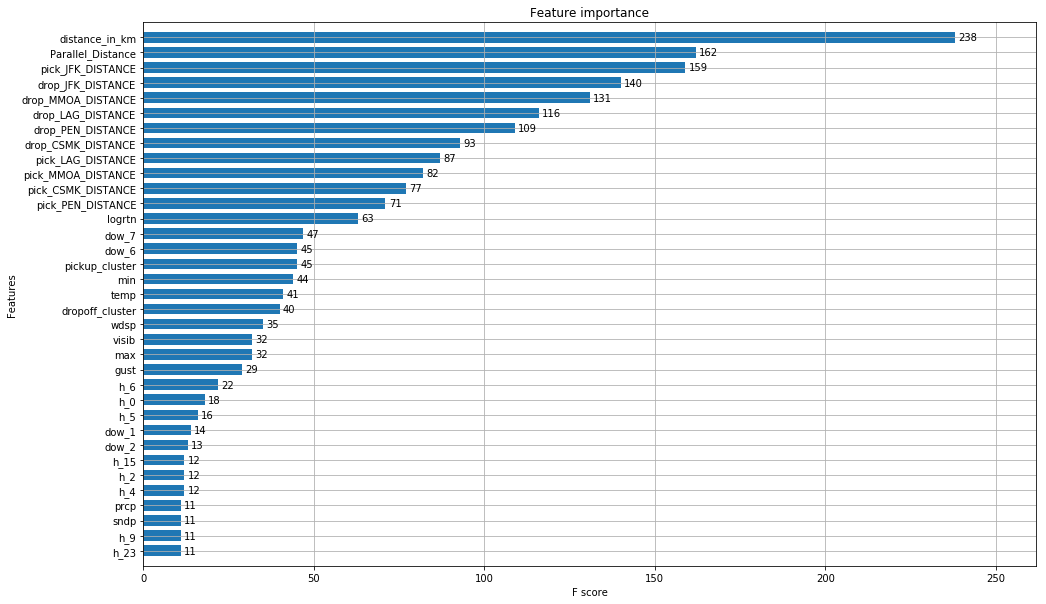

In [23]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(xgb_model, max_num_features=35, height=0.7)

### 5.3.6 Prediction

In [26]:
# get predicted duration
pred = xgb_model.predict(dtest) 
pred = np.exp(pred) -1
# get real dutation
Y_real =  np.exp(Y_testing) -1

print(np.sqrt(mean_squared_log_error(Y_real, pred )))

0.3673575795688253


When I tune the parameters, I found although tuning parameters could help improve the performance of the model but it could only improve the model a little bit. Adding right features could improve in a more efficient way. 

In [32]:
xgb = pd.concat([Y_real, pd.DataFrame(pred)], axis=1)  
#xgb['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)  
#xgb.to_csv("xgb.csv", index=False)  

## 5.4 Back-Propagation Neural Network 

In this part, we tried to build Back-Propagation(BP) neural network to estimate the duration of taxi trip.

### 5.4.1 Prepare data

In [3]:
def prepare_data(data):
    # drop useless columns
    dataset = data.drop(['date_of_year', 'date_of_year2', 'mo','da','trip_distance','speed'], axis = 1)
    dataset.loc[dataset.Parallel_Distance.isnull(), 'Parallel_Distance'] = dataset[dataset['Parallel_Distance'].isnull()]['distance_in_km'].values
    return dataset
dataset = prepare_data(taxi_data)
# dataset.describe()

### 5.4.2 Transform variables for the model

#### 5.4.2.1 Time
We extracted new two varaibles: hour and weekday from `pickup_datetime`. In terms of EA, these two features have siginificant impact on the taxi trip duration. 

In [4]:
# extracted new two varaibles: hour and weekday
def Extract_Time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    # as datetime cannot be used directly, drop it
    data = data.drop(['pickup_datetime'], axis = 1)
    return(data)
  
dataset = Extract_Time(dataset)
dataset.head(1)

,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn,pickup_hour,pickup_weekday
0,1770,40.769695,-73.863449,40.746578,-73.996208,1,11.458089,13.735808,0.524982,10.801247,21.271635,0.914609,4.608698,11.175251,0.934677,15.451244,12.351773,8.351602,63.8,10.0,2.8,999.9,82.0,44.1,0.0,999.9,0,0,0,0,0,0,0,0.651973,19,1


#### 2.2 Convert categorical variables to dummy bariables

In [5]:
# Transfrom categorical variables into dummy variables using one hot encode
def Dummy_One_Hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_') 
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_hour','pickup_weekday'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  passenger_count, hour, dow], axis=1)
    
    return(data)

dataset = Dummy_One_Hot(dataset)
dataset.head(1)

,travel_time,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_in_km,Parallel_Distance,drop_PEN_DISTANCE,drop_LAG_DISTANCE,drop_JFK_DISTANCE,drop_CSMK_DISTANCE,drop_MMOA_DISTANCE,pick_PEN_DISTANCE,pick_LAG_DISTANCE,pick_JFK_DISTANCE,pick_CSMK_DISTANCE,pick_MMOA_DISTANCE,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,common_holiday,key_holiday,logrtn,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,dow_7
0,1770,40.769695,-73.863449,40.746578,-73.996208,11.458089,13.735808,0.524982,10.801247,21.271635,0.914609,4.608698,11.175251,0.934677,15.451244,12.351773,8.351602,63.8,10.0,2.8,999.9,82.0,44.1,0.0,999.9,0,0,0,0,0,0,0,0.651973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


### 5.4.3 Train model
#### 5.4.3.1 Split data
We first splited data into training and testing data (80%, 20%).

In [6]:
train, test  = train_test_split(dataset, test_size=0.2, random_state=535)
def Split_x_y(data):
    X = data.values[:, 1:dataset.shape[1]]
    Y = data.values[:, 0]
    return X, Y
test_x, test_y = Split_x_y(test)

#### 5.4.3.2 Tune Model
In this part, we tried to find proper parameters, such as the number of network layers, nodes on each layer, epochs,  and batch size, by using `GridSearchCV()`.
Here is the param seach range:
```
{'nodes_num': [[256], [256, 128], [512], [128, 256], [128, 512], [512, 128], [128, 256, 64]], 
 'batch_size': [10,50,100],
 'epochs': [30, 50, 100]}
```

In [ ]:
# Split train into two parts again
train_build, train_valid = train_test_split(train, test_size=0.2, random_state=535)
X, Y = Split_x_y(train_build)

In [ ]:
# Proper Parameters Search
"""
    First Try:
    grid_params = {'nodes_num': [[256], [256, 128],[512],[128, 256]], 'batch_size': [10,50,100], 'epochs': [30, 50, 100]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256], 'epochs':[50]}
"""
grid_params = {'nodes_num': [[256], [256, 128],[512],[128, 256]], 'batch_size': [10,50,100], 'epochs': [30, 50, 100]}

grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)

In [ ]:
"""
    Second Try:
    grid_params = {'nodes_num': [[128, 256], [128, 512], [512, 128]]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256]}
"""
grid_params = {'nodes_num': [128, 256]}

grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)

In [ ]:
"""
    Third Try:
    grid_params = {'nodes_num': [[128, 256], [128, 256, 64]]}
    The best param:
    {'batch_size': 50, 'nodes_num': [128, 256, 64]}
"""
grid_params = {'nodes_num': [[128, 256], [128, 256, 64]]}

grid_result = My_GridSearchCV(grid_params, X, Y)
# summarize results
Summary_GridResult(grid_result)

Except the output layer, the activation function of all other leayers is Relu. MSLE is the loss function chosen to minimize. Finally, we decided to make hidden layers as [128, 256, 64], batch_size equal to 50, total epochs equal to 50. 

#### 5.4.3.3 Build BP NN
According to the result of GridSearchCv, we used the best parameter to build BP NN. Besides we used `Dropout()` to avoid overfitting.

In [8]:
# Split train into two parts again
train_build, train_valid = train_test_split(train, test_size=0.2, random_state=535)
train_build_x, train_build_y = Split_x_y(train_build)
train_valid_x, train_valid_y = Split_x_y(train_valid)

In [74]:
def Build_Model(input_dim = (dataset.shape[1]-1), nodes_num=[128, 256, 64], 
                lr=0.0008, decay=0.0, dropout = 0.1):
    n = len(nodes_num)
    # create model
    model = Sequential()
    for i in range(n):
        if i == 0:
            model.add(Dense(nodes_num[i], input_dim=input_dim, activation='relu', kernel_initializer='normal'))
            model.add(Dropout(dropout))
        else :
            model.add(Dense(nodes_num[i], activation='relu', kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))
    # plot model 
    plot_model(model, to_file='../img/model.png', show_shapes=True, show_layer_names=True)
    # set learing rate
    adam = optimizers.Adam(lr=lr, decay=decay)
    # Compile model
    model.compile(loss=losses.mean_squared_logarithmic_error, optimizer=adam, metrics=[rmsle_loss])
    return model
model =  Build_Model()
bp_result = model.fit(train_build_x, train_build_y, validation_data=(train_valid_x, train_valid_y), epochs=50, batch_size=50, verbose=2)

Train on 346844 samples, validate on 86711 samples
Epoch 1/50
 - 45s - loss: 0.3001 - rmsle_loss: 0.3870 - val_loss: 0.2078 - val_rmsle_loss: 0.3434
Epoch 2/50
 - 44s - loss: 0.1987 - rmsle_loss: 0.3319 - val_loss: 0.2002 - val_rmsle_loss: 0.3299
Epoch 3/50
 - 45s - loss: 0.1897 - rmsle_loss: 0.3225 - val_loss: 0.1739 - val_rmsle_loss: 0.3084
Epoch 4/50
 - 45s - loss: 0.1836 - rmsle_loss: 0.3161 - val_loss: 0.1745 - val_rmsle_loss: 0.3064
Epoch 5/50
 - 45s - loss: 0.1799 - rmsle_loss: 0.3125 - val_loss: 0.1733 - val_rmsle_loss: 0.3068
Epoch 6/50
 - 46s - loss: 0.1772 - rmsle_loss: 0.3096 - val_loss: 0.1673 - val_rmsle_loss: 0.2995
Epoch 7/50
 - 45s - loss: 0.1752 - rmsle_loss: 0.3075 - val_loss: 0.1723 - val_rmsle_loss: 0.3065
Epoch 8/50
 - 45s - loss: 0.1733 - rmsle_loss: 0.3057 - val_loss: 0.1756 - val_rmsle_loss: 0.3101
Epoch 9/50
 - 46s - loss: 0.1723 - rmsle_loss: 0.3045 - val_loss: 0.1739 - val_rmsle_loss: 0.3047
Epoch 10/50
 - 45s - loss: 0.1709 - rmsle_loss: 0.3027 - val_loss: 

Here is our final BP NN model.
<img src="model.png">

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'RMSLE_Loss')

Text(0.5, 0, 'Epoch')

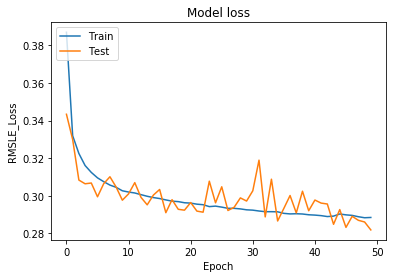

In [76]:
# Plot training & validation loss values
plt.plot(bp_result.history['rmsle_loss'])
plt.plot(bp_result.history['val_rmsle_loss'])
plt.title('Model loss')
plt.ylabel('RMSLE_Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [82]:
# save the model to disk
filename = '../img/finalized_model.h5'
model.save(filename)

### 5.4.4 Prediction

In [11]:
# load the model from disk with custom objects
# filename = '../img/finalized_model.h5'
filename = 'finalized_model.h5'
loaded_model = load_model(filename , custom_objects={'rmsle_loss': rmsle_loss})

# loaded_model
adam = optimizers.Adam(lr=0.0008)
loaded_model.compile(loss=losses.mean_squared_logarithmic_error, optimizer=adam, metrics=[rmsle_loss])

In [13]:
# predict
y_pred = loaded_model.predict(test_x)

In [15]:
np.sqrt(mean_squared_log_error(test_y, y_pred))

0.3866344918259829

The RMSLE of the prediction on `test` calculated by our final BP NN model is 0.3866.

In [44]:
# Save the result to disk as csv
y = list(x[0] for x in y_pred)
result_dict = {'true_value': test_y, 'prediction': y}
bp = pd.DataFrame(result_dict)

#bp.to_csv('NN_pred_result.csv', index = False)

# Step 6 Performance Comparison

## 6.1 Combine the predictions

In [35]:
predictions = pd.concat([bp,xgb["predictions-XGB"]  ,
                          dtree["predictions-decistion tree"],
                          lasso["predictions-lasso"]], axis=1)
predictions.head()

,true_value,predictions-BPNN,predictions-XGB,predictions-decistion tree,predictions-lasso
0,908.0,650.063477,584.07965,771.000000,712.928525
1,631.0,716.676331,723.05096,798.348438,593.960674
2,895.0,741.166199,671.48780,760.395062,661.742954
3,520.0,651.872925,791.06506,681.160045,596.717028
4,587.0,694.319397,724.22720,895.048780,873.868564


## 6.2 Compare RMSLE, RMSE, R2

In [58]:
result_compare = modelcompare(xgb,bp,dtree,lasso)
result_compare

,Model,RMSLE,RMSE,R2
0,XGB,0.367358,329.674870,0.752061
1,BP NN,0.386634,344.554001,0.729176
2,Decision Tree,0.435618,385.296722,0.661340
3,Lasso,0.532144,419.219418,0.599082


# Step 7 Important Features

**To conclude, the distance plays a important role in deciding the travel time. Te be more specific, the travel distance and the distance to the main hub of communication: for example, the JFK airport, LaGuardia Airport, Penn station, Metropolitan museum and Chelsea market will determine the length of travel time.**

**Besides of these, from the importance plot of linear model, extreme weather will influence on the duration of travel.**

**From the result of XGboost and decision tree, the log return of stock market also has relation with the travel time.**


## 7.1 Important features in XGboost

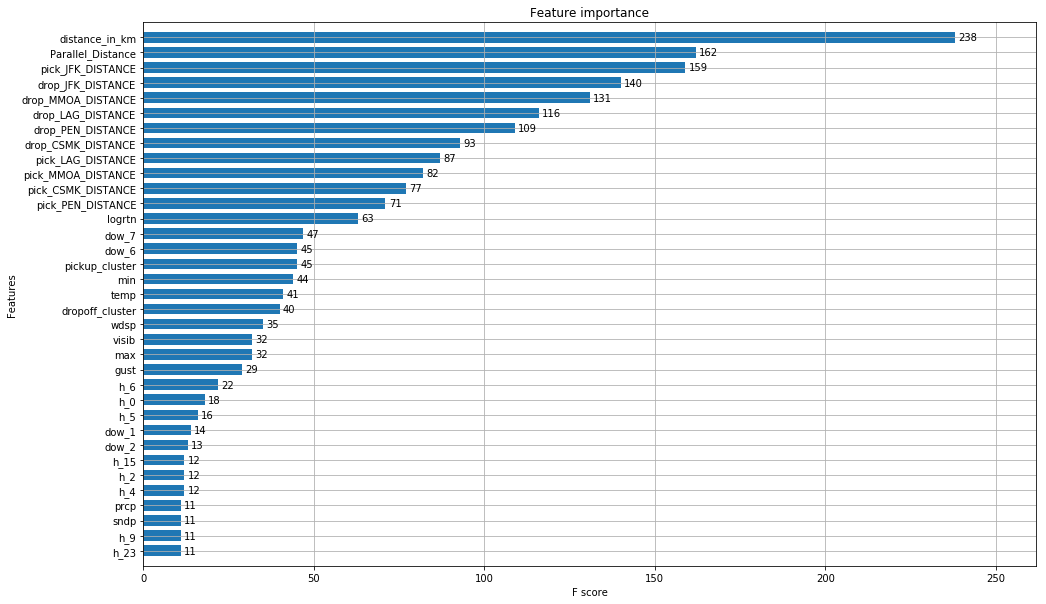

In [23]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(xgb_model, max_num_features=35, height=0.7)

## 7.2 Important features in Decision Tree

([<matplotlib.axis.YTick at 0x1a1bdf5cf8>,
 <a list of 16 Text yticklabel objects>)

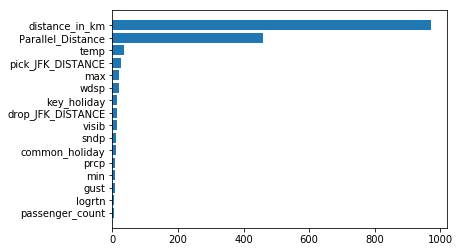

In [83]:
import matplotlib.pyplot as plt
y = abs(L_model.coef_)
coef_ = pd.DataFrame(y)
coef_.columns = ['value']
coef_['coef'] =  X_test.columns
coef_ = coef_.sort_values(ascending=True, by=['value'])

x0 = np.linspace(1,16,16)

plt.barh(x0, coef_.value)
plt.yticks(x0, coef_.coef)

## 7.3 Important features in Lasso 

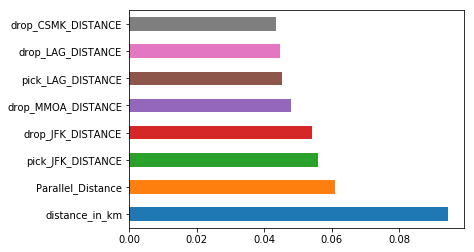

0    0.094425
1    0.061055
9    0.055773
4    0.054085
6    0.047961
8    0.045147
3    0.044644
5    0.043508
dtype: float64


In [25]:
colname = ['distance_in_km','Parallel_Distance','pick_JFK_DISTANCE','drop_JFK_DISTANCE',
 'drop_MMOA_DISTANCE','pick_LAG_DISTANCE','drop_LAG_DISTANCE','drop_CSMK_DISTANCE']
fidt.nlargest(8).plot(kind='barh')
plt.yticks(range(0,8),colname)

plt.show()
print(fidt.nlargest(8))

# Step 8 Extra interesting ideas

**Stock prices is influenced by many factors that includes**
<br>&emsp;&emsp;**1. Overall performance of the company.**
<br>&emsp;&emsp; **2. General environment** 
<br>&emsp;&emsp;**3. Energy market**

**Since NYC is a global hub of finance, these factors may also influence on how people live so we decide to add this factor as a comprehensive factor for duration.**